In [160]:
nodes["Argentina"].keys()

dict_keys(['aexp', 'confirmed_curve', 'coordinates', 'deaths_curve', 'err_aexp', 'initial_day', 'initial_immunized', 'initial_infected', 'peak', 'population', 'recovered_curve', 'tinc'])

In [31]:
%matplotlib inline
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
import pandas as pd
import json



from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.animation as animation
from IPython.display import HTML


data = pd.read_json("../Datos/data.json")
nodes = {}
for d in data:
    nodes[d] = {}
    for entry in  data[d].keys():
        nodes[d][entry] =  data[d][entry]



class SIRTsimSingleNode:
    def __init__(self, node, incubation_time=12, difussion=None, map=None, extent=None):
        if map is None:
            map = 'https://upload.wikimedia.org/wikipedia/commons/thumb/c/cf/Map_of_Argentina_with_provinces_names_es.png/362px-Map_of_Argentina_with_provinces_names_es.png'
        if extent is None:
            self.extent = [-74.5,-48,-57,-20.5]
        else:
            self.extent = extent
        try:
            self.map = plt.imread(map)
        except:
            self.map = None
            
        self.nodes = nodes
        self.difussion_matrix = difussion
        self.totalpop = 0
        self.node_populations = np.zeros(len(nodes),dtype=float)
        self.ps = np.zeros(len(nodes))
        self.aexps = np.zeros(len(nodes))
        self.incubation_time = incubation_time
        self.reset_history()
        
    def reset_history(self):
        initial_state = np.zeros((3, len(self.nodes)),dtype=float)
        for i, key in enumerate(self.nodes):
            self.node_populations[i] = self.nodes[key]["population"]
            #self.incubation_time.append(int(self.nodes[key]["tinc"]))
            initial_state[1,i] = self.nodes[key]["initial_infected"]
            initial_state[2,i] = self.nodes[key]["initial_immunized"]
            initial_state[0,i] = self.node_populations[i]  - initial_state[1,i] -\
                                 initial_state[2,i]
            self.aexps[i] = self.nodes[key]["aexp"]
        self.history = [initial_state]
        self.ps = (self.aexps-1) / self.node_populations
    
    def show_infected(self, ax=None, day=-1, scale=.1, **args):
        if ax is None:
            fig, ax = plt.subplots()
            ax.set_xlim(self.extent[0],self.extent[1])
            ax.set_ylim(self.extent[2],self.extent[3])

        nodes_coordinates = []
        if map is not None:
            ax.imshow(self.map, 
                  extent=self.extent, alpha=0.5)
        for i, key in enumerate(self.nodes):
            nodes_coordinates.append(self.nodes[key]["coordinates"])
        nodes_coordinates = np.array(nodes_coordinates)
        print("coordinates", nodes_coordinates[:,0],nodes_coordinates[:,1])
        return ax.scatter(nodes_coordinates[:,0], 
                   nodes_coordinates[:,1], 
                   s=(scale*self.history[day][1,:]), 
                   alpha=0.5,*args)

    def show_animated_evolution(self,ax=None,scale=2,**args):
        if ax is None:
            fig, ax = plt.subplots(figsize=(20,30))
            close_when_finished = True
        else:
            close_when_finished = False
            
        nodes_coordinates = []
        for i, key in enumerate(self.nodes):
            nodes_coordinates.append(self.nodes[key]["coordinates"])
        nodes_coordinates = np.array(nodes_coordinates)
        if map is not None:
            ax.imshow(self.map, 
                  extent=self.extent, alpha=0.5)
        
        ax.set_xlim(self.extent[0],self.extent[1])
        ax.set_ylim(self.extent[2],self.extent[3])        
        points = ax.scatter(nodes_coordinates[:,0], 
                   nodes_coordinates[:,1], 
                   s=(scale*self.history[0][1,:]), 
                   alpha=0.5)
        daylabel = ax.text(.1, .1, "day 0")
        def update_fig(day):
            daylabel.set_text("day " + str(day))
            points.set_sizes(scale*np.log(self.history[day][1,:]))
            return points, daylabel
            
        ss_anim = animation.FuncAnimation(fig, 
                                          update_fig,                                                                                  
                                          len(self.history),
                                          interval=50, 
                                          blit=True, 
                                          repeat=False)
        res = HTML(ss_anim.to_jshtml())
        if close_when_finished:
            plt.close()
        return res

    def show_global_evolution(self,ax=None):
        if ax is None:
            fig, ax = plt.subplots()

        total_susceptibles = np.array([1.e-6 * sum(state[0,:]) for state in self.history])
        total_infected     = np.array([1.e-6 * sum(state[1,:]) for state in self.history])
        total_recovered    = np.array([1.e-6 * sum(state[2,:]) for state in self.history])    
        total = total_susceptibles + total_infected + total_recovered
        ax.plot(total_susceptibles,label="susceptibles")
        ax.plot(total_infected,label="infected")
        ax.plot(total_recovered,label="recuperados")
        ax.plot(total,label="total")
        ax.legend()
        return ax

    def show_local_evolution(self, ax=None, var=1,regions=None):
        if ax is None:
            fig, ax = plt.subplots()

        h = np.array(self.history)
        ts = np.linspace(0.,1.*len(h),len(h))
        for idx,key in enumerate(self.nodes):
            if regions is not None and key not in regions:
                continue
            ax.plot(ts, 1.e-6 * h[:,var,idx],label=key)
        ax.legend()
        ax.set_ylabel("M")
        return ax
    
    def evolve(self,days=1):
        for day in range(days):
            self.evolve_single_day()
    
    def evolve_single_day(self):
        curr_state = self.history[-1]
        curr_suceptible = curr_state[0]
        curr_infected = curr_state[1]
        curr_recovered =   curr_state[2]
               
        if len(self.history) > self.incubation_time:
            rec_state =  self.history[-self.incubation_time]
            old_infected = self.ps * rec_state[1] * rec_state[0] 
            new_recovered = old_infected 
        elif len(self.history) == self.incubation_time:
            rec_state =  self.history[-self.incubation_time]
            old_infected =  rec_state[1] 
            new_recovered = old_infected
        else:
            new_recovered = np.zeros(len(self.nodes)) 
        new_infected = self.ps *  curr_infected * curr_suceptible
        
        # migrations. Moved before update to be consistent with the notes.
        if self.difussion_matrix is not None:
            curr_suceptible = np.dot(self.difussion_matrix, curr_suceptible)
            curr_infected =    np.dot(self.difussion_matrix, curr_infected)
            curr_recovered =   np.dot(self.difussion_matrix, curr_recovered)
            self.node_populations = curr_suceptible + curr_infected \
                                    + curr_recovered
        
        
        new_suceptibles = curr_suceptible - new_infected
        new_suceptibles = np.array([s if s>0 else 0 for s in new_suceptibles])
        new_infected = curr_infected + new_infected - new_recovered
        new_infected = np.array([i if i>0 else 0 for i in new_infected])
        new_recovered = self.node_populations - new_infected - new_suceptibles
        new_recovered = np.array([i if i>0 else 0 for i in new_recovered])
        self.history.append(np.array([new_suceptibles, 
                                       new_infected, 
                                       new_recovered]))
        

class SIRTsim:
    def __init__(self, nodes, incubation_time=12, difussion=None, map=None, extent=None):
        if map is None:
            map = 'https://upload.wikimedia.org/wikipedia/commons/thumb/c/cf/Map_of_Argentina_with_provinces_names_es.png/362px-Map_of_Argentina_with_provinces_names_es.png'
        if extent is None:
            self.extent = [-74.5,-48,-57,-20.5]
        else:
            self.extent = extent
        try:
            self.map = plt.imread(map)
        except:
            self.map = None
            
        self.nodes = nodes
        self.difussion_matrix = difussion
        self.totalpop = 0
        self.node_populations = np.zeros(len(nodes),dtype=float)
        self.ps = np.zeros(len(nodes))
        self.aexps = np.zeros(len(nodes))
        self.incubation_time = incubation_time
        self.reset_history()
        
    def reset_history(self):
        initial_state = np.zeros((3, len(self.nodes)),dtype=float)
        for i, key in enumerate(self.nodes):
            self.node_populations[i] = self.nodes[key]["population"]
            #self.incubation_time.append(int(self.nodes[key]["tinc"]))
            initial_state[1,i] = self.nodes[key]["initial_infected"]
            initial_state[2,i] = self.nodes[key]["initial_immunized"]
            initial_state[0,i] = self.node_populations[i]  - initial_state[1,i] -\
                                 initial_state[2,i]
            self.aexps[i] = self.nodes[key]["aexp"]
        self.history = [initial_state]
        self.ps = (self.aexps-1) / self.node_populations
    
    def show_infected(self, ax=None, day=-1, scale=.1, **args):
        if ax is None:
            fig, ax = plt.subplots()
            ax.set_xlim(self.extent[0],self.extent[1])
            ax.set_ylim(self.extent[2],self.extent[3])

        nodes_coordinates = []
        if map is not None:
            ax.imshow(self.map, 
                  extent=self.extent, alpha=0.5)
        for i, key in enumerate(self.nodes):
            nodes_coordinates.append(self.nodes[key]["coordinates"])
        nodes_coordinates = np.array(nodes_coordinates)
        print("coordinates", nodes_coordinates[:,0],nodes_coordinates[:,1])
        return ax.scatter(nodes_coordinates[:,0], 
                   nodes_coordinates[:,1], 
                   s=(scale*self.history[day][1,:]), 
                   alpha=0.5,*args)

    def show_animated_evolution(self,ax=None,scale=2,**args):
        if ax is None:
            fig, ax = plt.subplots(figsize=(20,30))
            close_when_finished = True
        else:
            close_when_finished = False
            
        nodes_coordinates = []
        for i, key in enumerate(self.nodes):
            nodes_coordinates.append(self.nodes[key]["coordinates"])
        nodes_coordinates = np.array(nodes_coordinates)
        if map is not None:
            ax.imshow(self.map, 
                  extent=self.extent, alpha=0.5)
        
        ax.set_xlim(self.extent[0],self.extent[1])
        ax.set_ylim(self.extent[2],self.extent[3])        
        points = ax.scatter(nodes_coordinates[:,0], 
                   nodes_coordinates[:,1], 
                   s=(scale*self.history[0][1,:]), 
                   alpha=0.5)
        daylabel = ax.text(.1, .1, "day 0")
        def update_fig(day):
            daylabel.set_text("day " + str(day))
            points.set_sizes(scale*np.log(self.history[day][1,:]))
            return points, daylabel
            
        ss_anim = animation.FuncAnimation(fig, 
                                          update_fig,                                                                                  
                                          len(self.history),
                                          interval=50, 
                                          blit=True, 
                                          repeat=False)
        res = HTML(ss_anim.to_jshtml())
        if close_when_finished:
            plt.close()
        return res

    def show_global_evolution(self,ax=None):
        if ax is None:
            fig, ax = plt.subplots()

        total_susceptibles = np.array([1.e-6 * sum(state[0,:]) for state in self.history])
        total_infected     = np.array([1.e-6 * sum(state[1,:]) for state in self.history])
        total_recovered    = np.array([1.e-6 * sum(state[2,:]) for state in self.history])    
        total = total_susceptibles + total_infected + total_recovered
        ax.plot(total_susceptibles,label="susceptibles")
        ax.plot(total_infected,label="infected")
        ax.plot(total_recovered,label="recuperados")
        ax.plot(total,label="total")
        ax.legend()
        return ax

    def show_local_evolution(self, ax=None, var=1,regions=None):
        if ax is None:
            fig, ax = plt.subplots()

        h = np.array(self.history)
        ts = np.linspace(0.,1.*len(h),len(h))
        for idx,key in enumerate(self.nodes):
            if regions is not None and key not in regions:
                continue
            ax.plot(ts, 1.e-6 * h[:,var,idx],label=key)
        ax.legend()
        ax.set_ylabel("M")
        return ax
    
    def evolve(self,days=1):
        for day in range(days):
            self.evolve_single_day()
    
    def evolve_single_day(self):
        curr_state = self.history[-1]
        curr_suceptible = curr_state[0]
        curr_infected = curr_state[1]
        curr_recovered =   curr_state[2]
               
        if len(self.history) > self.incubation_time:
            rec_state =  self.history[-self.incubation_time]
            old_infected = self.ps * rec_state[1] * rec_state[0] 
            new_recovered = old_infected 
        elif len(self.history) == self.incubation_time:
            rec_state =  self.history[-self.incubation_time]
            old_infected =  rec_state[1] 
            new_recovered = old_infected
        else:
            new_recovered = np.zeros(len(self.nodes)) 
        new_infected = self.ps *  curr_infected * curr_suceptible
        
        # migrations. Moved before update to be consistent with the notes.
        if self.difussion_matrix is not None:
            curr_suceptible = np.dot(self.difussion_matrix, curr_suceptible)
            curr_infected =    np.dot(self.difussion_matrix, curr_infected)
            curr_recovered =   np.dot(self.difussion_matrix, curr_recovered)
            self.node_populations = curr_suceptible + curr_infected \
                                    + curr_recovered
        
        
        new_suceptibles = curr_suceptible - new_infected
        new_suceptibles = np.array([s if s>0 else 0 for s in new_suceptibles])
        new_infected = curr_infected + new_infected - new_recovered
        new_infected = np.array([i if i>0 else 0 for i in new_infected])
        new_recovered = self.node_populations - new_infected - new_suceptibles
        new_recovered = np.array([i if i>0 else 0 for i in new_recovered])
        self.history.append(np.array([new_suceptibles, 
                                       new_infected, 
                                       new_recovered]))
        
    def compare_with_data(self, tinc, aexp):
        pass
        
    
            
    



In [12]:
#fig, ax = plt.subplots(figsize=(8,12))
#ax.set_xlim(-75,-47)
#ax.set_ylim(-57,-20)

sim = SIRTsim(nodes,difussion=None,extent=[-74.5,-48,-57,-20.5])

#sim.evolve(300)
#sim.show_local_evolution(regions=["Argentina"])
#sim.fit_parameters_node("Argentina")

In [25]:
nodes["US"]["curve_confirmed"]

[1.0,
 1.0,
 2.0,
 2.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 7.0,
 8.0,
 8.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 11.0,
 12.0,
 12.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 13.0,
 15.0,
 15.0,
 15.0,
 51.0,
 51.0,
 57.0,
 58.0,
 60.0,
 68.0,
 74.0,
 98.0,
 118.0,
 149.0,
 217.0,
 262.0,
 402.0,
 518.0,
 583.0,
 959.0,
 1281.0,
 1663.0,
 2179.0,
 2727.0,
 3499.0,
 4632.0,
 6421.0,
 7783.0,
 13747.0,
 19273.0,
 25600.0,
 33276.0,
 43847.0,
 53740.0,
 65778.0,
 83836.0,
 101657.0,
 121465.0,
 140909.0,
 161831.0,
 188172.0,
 213372.0,
 243762.0,
 275586.0,
 308853.0,
 337072.0,
 366667.0,
 396223.0,
 429052.0,
 461437.0,
 496535.0,
 526396.0,
 555313.0,
 580619.0]

Text(0.5, 1.0, 'aexp for UK')

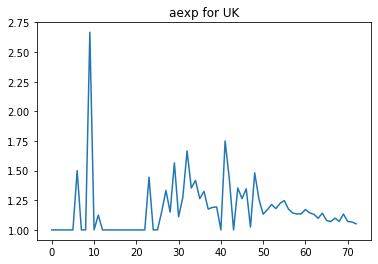

In [34]:
data=np.array(nodes["United Kingdom"]["curve_confirmed"][nodes["United Kingdom"]["initial_day"]:])
plt.plot(data[1:]/data[:-1])
plt.title("aexp for UK")

Text(0.5, 1.0, ' log of confirmed for US')

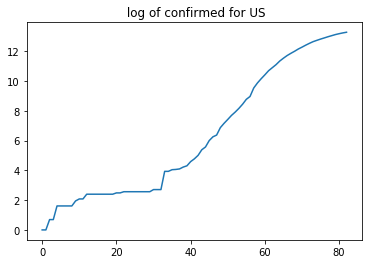

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


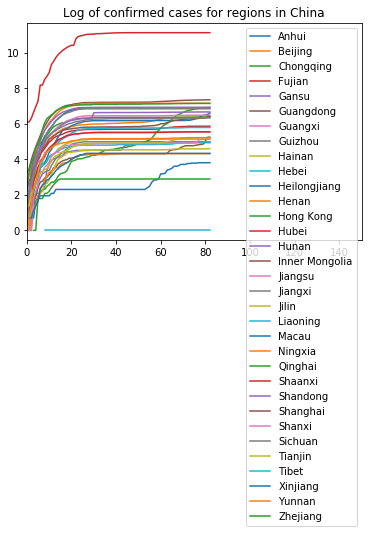

In [59]:
for key in nodes:
    if not key.startswith("China-"):
        continue
    data=np.array(nodes[key]["curve_confirmed"])
    plt.plot(np.log(data),label=key[6:])

plt.xlim(0,150)
plt.title("Log of confirmed cases for regions in China")
plt.legend()

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


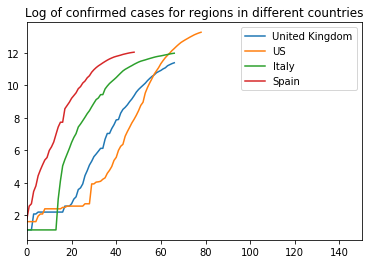

In [68]:
for key in ["United Kingdom","US","Italy","Spain"]:
    data=np.array(nodes[key]["curve_confirmed"])
    data = np.log(data) 
    data = data[data>1]
    plt.plot(data,label=key)

plt.xlim(0,150)
plt.title("Log of confirmed cases for regions in different countries")
plt.legend()

In [74]:
for key in nodes:
    if not key.startswith("China-"):
        continue

(array([ 7.14846513, 12.7470327 , 12.07857755, 12.2537845 ]),
 array([[ 2.07927909, -1.17034279, -1.29033621, -0.17252139],
        [-1.17034279,  0.74561152,  0.77390911,  0.12169951],
        [-1.29033621,  0.77390911,  0.83148174,  0.12193606],
        [-0.17252139,  0.12169951,  0.12193606,  0.02183688]]))

United Kingdom
US
Italy
Spain


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log


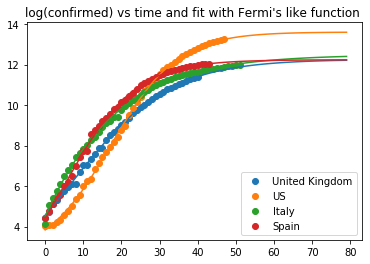

China-Anhui
Unable to fit  China-Anhui
China-Beijing
Unable to fit  China-Beijing
China-Chongqing
China-Fujian
Unable to fit  China-Fujian
China-Gansu
Unable to fit  China-Gansu
China-Guangdong
China-Guangxi
Unable to fit  China-Guangxi
China-Guizhou
Unable to fit  China-Guizhou
China-Hainan
Unable to fit  China-Hainan
China-Hebei
Unable to fit  China-Hebei
China-Heilongjiang
Unable to fit  China-Heilongjiang
China-Henan
Unable to fit  China-Henan
China-Hong Kong
Unable to fit  China-Hong Kong
China-Hubei
Unable to fit  China-Hubei
China-Hunan
Unable to fit  China-Hunan
China-Inner Mongolia
Unable to fit  China-Inner Mongolia
China-Jiangsu
Unable to fit  China-Jiangsu
China-Jiangxi
Unable to fit  China-Jiangxi
China-Jilin
Unable to fit  China-Jilin
China-Liaoning
Unable to fit  China-Liaoning
China-Macau
China-Ningxia
Unable to fit  China-Ningxia
China-Qinghai
China-Shaanxi
Unable to fit  China-Shaanxi
China-Shandong
Unable to fit  China-Shandong
China-Shanghai
Unable to fit  China-Sha

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log


Unable to fit  China-Shanxi
China-Sichuan
Unable to fit  China-Sichuan
China-Tianjin
Unable to fit  China-Tianjin
China-Tibet
China-Xinjiang
Unable to fit  China-Xinjiang
China-Yunnan
Unable to fit  China-Yunnan
China-Zhejiang
cargando diccionario


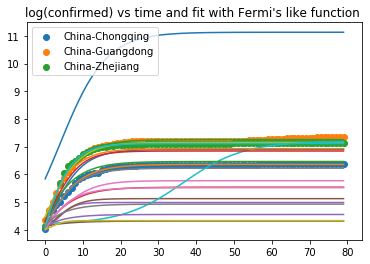

In [128]:
import scipy.optimize as scopt
%matplotlib inline
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
import pandas as pd
import json



from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.animation as animation
from IPython.display import HTML


data = pd.read_json("../Datos/data.json")
nodes = {}
for d in data:
    nodes[d] = {}
    for entry in  data[d].keys():
        nodes[d][entry] =  data[d][entry]


        
dictparms = {}


def  fermi(x,x0,a,h1,h0):
    if x is np.ndarray:
        return np.array([fermi(xc,x0,a,h1,h0) for xc in x])
    else:
        return (h1-h0)/(1.+np.exp((x0-x)/a)) + h0

labels = []
x0s = []
aes = []
h1s = []
h0s = []
t0overaes = []
    
    
for key in ["United Kingdom","US","Italy","Spain"]:
    data = np.array(nodes[key]["curve_confirmed"])
    data = np.log(data)
    data = data[data>4]
    days = np.array(range(len(data)))
    print(key)
    if len(data)<8:
        continue    
    fit, cov = scopt.curve_fit(fermi,days,data)
    plt.scatter(days,data,label=key)
    days = np.array(range(80))
    labels.append(key)
    x0s.append(fit[0])
    aes.append(fit[1])
    h1s.append(fit[2])
    h0s.append(fit[3])
    t0overaes.append(fit[0]/fit[1])
    
    plt.plot(days,fermi(days,*fit))
plt.legend()
plt.title("log(confirmed) vs time and fit with Fermi's like function ")




plt.show()

for key in nodes:
    if not key.startswith("China-"):
        continue
    data = np.array(nodes[key]["curve_confirmed"])
    data = np.log(data)
    data = data[data>4]
    print(key)
    if len(data)<8:
        continue
    days = np.array(range(len(data)))
    try:
        fit, cov = scopt.curve_fit(fermi,days,data)
        days = np.array(range(80))
        if fit[0]<-60 or fit[0]>60 :
            print("Unable to fit ", key)
            continue        
        labels.append(key)
        x0s.append(fit[0])
        aes.append(fit[1])
        h1s.append(fit[2])
        h0s.append(fit[3])
        t0overaes.append(fit[0]/fit[1])        
        plt.plot(days,fermi(days,*fit))
        plt.scatter(days,data,label=key)
    except:
        print("Unable to fit ", key)
        continue
plt.legend()
plt.title("log(confirmed) vs time and fit with Fermi's like function ")

print("cargando diccionario")

dictparms["Region"] = labels
dictparms["x0"] = x0s
dictparms["a"] = aes
dictparms["h0"] = h0s
dictparms["h1"] = h1s
dictparms["t0/a"] = t0overaes
ajustes=pd.DataFrame(dictparms)


In [130]:
ajustes

,Region,x0,a,h0,h1,t0/a
0,United Kingdom,7.148469,12.747031,0.175209,12.253784,0.560795
1,US,17.282351,8.743850,2.484890,13.602053,1.976515
2,Italy,-37.745157,17.084408,-68.175255,12.485328,-2.209334
3,Spain,5.280707,9.143287,0.007174,12.233513,0.577550
4,China-Anhui,0.020170,4.602656,1.219329,6.902964,0.004382
5,China-Chongqing,-4.282016,5.420090,-0.994803,6.360720,-0.790027
6,China-Guangdong,-4.324724,5.211892,-2.374249,7.255107,-0.829780
7,China-Guangxi,-5.372271,5.549275,0.358346,5.536423,-0.968103
8,China-Guizhou,3.657660,2.060629,3.923023,4.984609,1.775021
9,China-Hainan,2.799258,3.101940,3.669814,5.123997,0.902422


Text(0.5, 1.0, 'confirmed for GB')

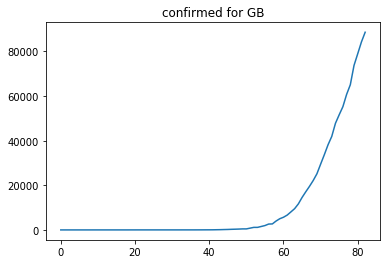

In [33]:
data=np.array(nodes["United Kingdom"]["curve_confirmed"])
plt.plot(data)
plt.title("confirmed for GB")

coordinates [-63.6167 -51.9253 -71.543  117.2264 116.4142 107.874  117.9874 101.0583
 113.4244 108.7881 106.8748 109.7453 116.1306 127.7615 113.614  114.2
 112.2707 111.7088 113.9448 119.455  115.7221 126.1923 122.6085 113.55
 106.1655  95.9956 108.8701 118.1498 121.4491 112.2922 102.7103 117.323
  88.0924  85.2401 101.487  120.0934  12.      -4.     -55.7658] [-38.4161 -14.235  -35.6751  31.8257  40.1824  30.0572  26.0789  37.8099
  23.3417  23.8298  26.8154  19.1959  39.549   47.862   33.882   22.3
  30.9756  27.6104  44.0935  32.9711  27.614   43.6661  41.2956  22.1667
  37.2692  35.7452  35.1917  36.3427  31.202   37.5777  30.6171  39.3054
  31.6927  41.1129  24.974   29.1832  43.      40.     -32.5228]


ValueError: operands could not be broadcast together with shapes (2,) (39,) 

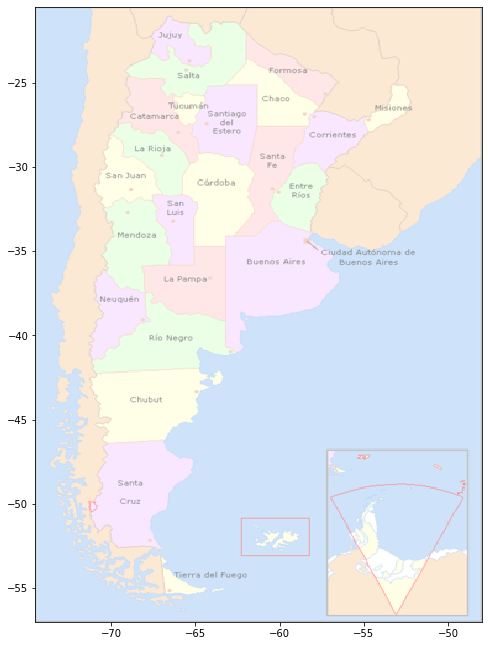

In [62]:
difusion1=np.array([[1,.0],[.0,1.]])

fig, ax = plt.subplots(figsize=(8,12))

sim = SIRTsim(nodes,difussion=None,extent=[-74.5,-48,-57,-20.5])
#sim.evolve(120)
sim.show_infected(ax=ax,scale=[1,1],regions)


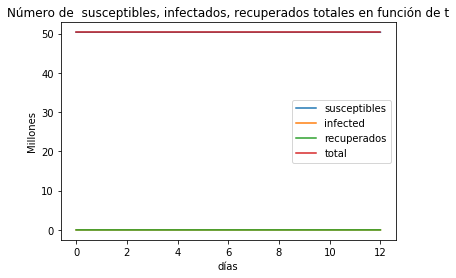

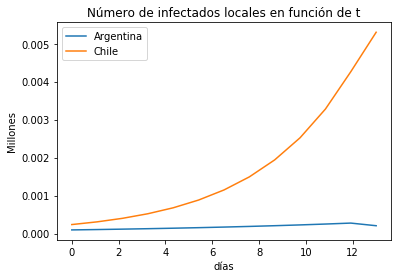

In [37]:
difusion1=np.array([[1,.0],[.0,1.]])


sim = SIRTsim(nodes,difussion=difusion1)
sim.evolve(12)
ax = sim.show_global_evolution()
ax.set_title("Número de  susceptibles, infectados, recuperados totales en función de t")
ax.set_ylabel("Millones")
ax.set_xlabel("días")
plt.show()

ax = sim.show_local_evolution()
ax.set_title("Número de infectados locales en función de t")
ax.set_ylabel("Millones")
ax.set_xlabel("días")
plt.show()



{'_stale': True,
 'stale_callback': <function matplotlib.artist._stale_axes_callback(self, val)>,
 '_axes': <matplotlib.axes._subplots.AxesSubplot at 0x7fd6f5694e48>,
 'figure': <Figure size 432x288 with 1 Axes>,
 '_transform': <matplotlib.transforms.IdentityTransform at 0x7fd6f69d8898>,
 '_transformSet': True,
 '_visible': True,
 '_animated': False,
 '_alpha': None,
 'clipbox': <matplotlib.transforms.TransformedBbox at 0x7fd6f6d1eb00>,
 '_clippath': None,
 '_clipon': True,
 '_label': '_collection0',
 '_picker': None,
 '_contains': None,
 '_rasterized': None,
 '_agg_filter': None,
 '_mouseover': False,
 'eventson': False,
 '_oid': 0,
 '_propobservers': {},
 '_remove_method': <function list.remove>,
 '_url': None,
 '_gid': None,
 '_snap': None,
 '_sketch': None,
 '_path_effects': None,
 '_sticky_edges': _XYPair(x=[], y=[]),
 '_in_layout': True,
 'callbacksSM': <matplotlib.cbook.CallbackRegistry at 0x7fd6f69d8908>,
 '_A': None,
 'norm': <matplotlib.colors.Normalize at 0x7fd6f69d8780>,
 '

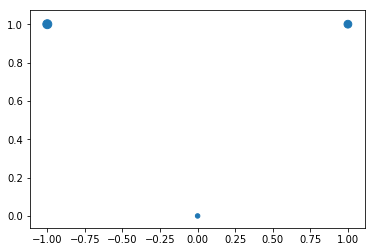

In [38]:
fig,ax = plt.subplots()

pts=ax.scatter([0,1,-1],[0,1,1],s=[20,60,80])
pts.__dict__

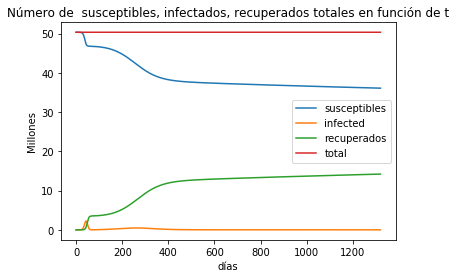

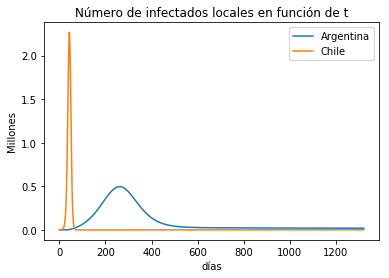

In [7]:
movilidad = 0.0001


difusion1=np.array([[1-nodes["Chile"]["population"]/nodes["Argentina"]["population"]*movilidad,movilidad],
                    [nodes["Chile"]["population"]/nodes["Argentina"]["population"]*movilidad,1.-movilidad]])


sim = SIRTsim(nodes,difussion=difusion1)
sim.evolve(1320)
ax = sim.show_global_evolution()
ax.set_title("Número de  susceptibles, infectados, recuperados totales en función de t")
ax.set_ylabel("Millones")
ax.set_xlabel("días")
plt.show()

ax = sim.show_local_evolution(var=1 )
ax.set_title("Número de infectados locales en función de t")
ax.set_ylabel("Millones")
ax.set_xlabel("días")
plt.show()



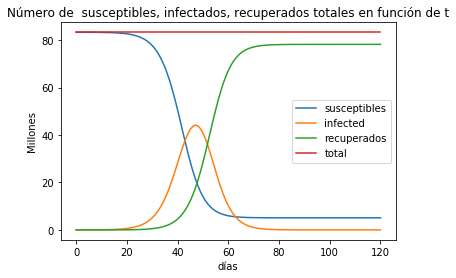

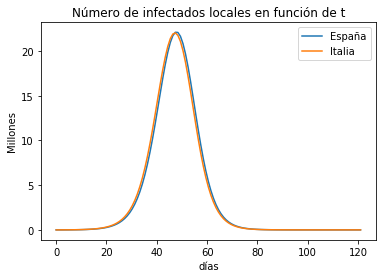

In [23]:
difusion1=np.array([[.5,.5],[.5,.5]])


sim = SIRTsim(nodes,difussion=difusion1)
sim.evolve(120)
ax = sim.show_global_evolution()
ax.set_title("Número de  susceptibles, infectados, recuperados totales en función de t")
ax.set_ylabel("Millones")
ax.set_xlabel("días")
plt.show()

ax = sim.show_local_evolution()
ax.set_title("Número de infectados locales en función de t")
ax.set_ylabel("Millones")
ax.set_xlabel("días")
plt.show()

In [48]:
p0 = np.array([45000000,19000000])
pi = p0 * np.array([.05,.2])
pr = p0 - pi
a = .1
b = .2

difussion = np.array([[(1-a),a*p0[0]/p0[1]],[b*p0[1]/p0[0],1-b]])


print("totales iniciales:")
print("    infectados:", sum(pi))
print("    resto:", sum(pr))
print("    total:", sum(pr+pi))

print("")
print("totales luego de un paso:")
print("    infectados:", sum(np.dot(difussion,pi)))
print("    resto:", sum(np.dot(difussion,pr)))
print("    total:", sum(np.dot(difussion,pr+pi)))


for i in range(100):
    pi = np.dot(difussion,pi)
    pr = np.dot(difussion,pr)
    

print("")
print("totales luego de cien pasos:")
print("    infectados:", sum(pi))
print("    resto:", sum(pr))
print("    total:", sum(pr+pi))


totales iniciales:
    infectados: 6050000.0
    resto: 57950000.0
    total: 64000000.0

totales luego de un paso:
    infectados: 6155000.0
    resto: 57845000.0
    total: 64000000.0

totales luego de cien pasos:
    infectados: 6400000.00000002
    resto: 57600000.00000015
    total: 64000000.00000017


In [4]:
f = lambda day: (a=day;print(a))

SyntaxError: invalid syntax (<ipython-input-4-8ac279b15028>, line 1)

In [57]:
from mpl_toolkits.basemap import Basemap

map = Basemap(projection='ortho',lat_0=45,lon_0=-100,resolution='l')

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

In [58]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
# create new figure, axes instances.
fig=plt.figure()
ax=fig.add_axes([0.1,0.1,0.8,0.8])
# setup mercator map projection.
m = Basemap(llcrnrlon=-80.,llcrnrlat=-20.,urcrnrlon=20.,urcrnrlat=-60.,\
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',projection='merc',\
            lat_0=-40.,lon_0=-20.,lat_ts=-20.)
# nylat, nylon are lat/lon of New York
nylat = -33.78; nylon = -43.98
# lonlat, lonlon are lat/lon of London.
lonlat = 51.53; lonlon = 0.08
# draw great circle route between NY and London
m.drawgreatcircle(nylon,nylat,lonlon,lonlat,linewidth=2,color='b')
m.drawcoastlines()
m.fillcontinents()
# draw parallels
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
# draw meridians
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])
ax.set_title('Great Circle from New York to London')
plt.show()


ImportError: cannot import name 'is_scalar'

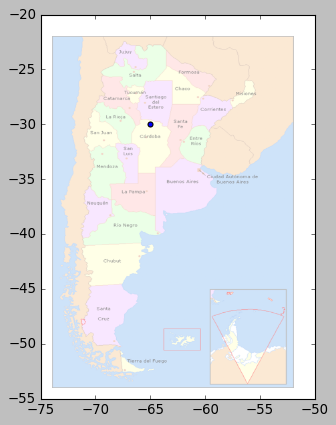

In [105]:
import urllib3 as urllib
import matplotlib.pyplot as plt




plt.scatter([-65],[-30])

ValueError: not enough values to unpack (expected 4, got 3)

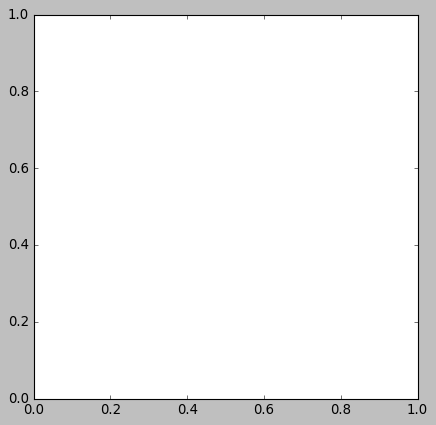

In [103]:
plt.style.use('classic')


In [84]:
help(plt.imshow)

Help on function imshow in module matplotlib.pyplot:

imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, shape=None, filternorm=1, filterrad=4.0, imlim=None, resample=None, url=None, *, data=None, **kwargs)
    Display an image, i.e. data on a 2D regular raster.
    
    Parameters
    ----------
    X : array-like or PIL image
        The image data. Supported array shapes are:
    
        - (M, N): an image with scalar data. The data is visualized
          using a colormap.
        - (M, N, 3): an image with RGB values (float or uint8).
        - (M, N, 4): an image with RGBA values (float or uint8), i.e.
          including transparency.
    
        The first two dimensions (M, N) define the rows and columns of
        the image.
    
        The RGB(A) values should be in the range [0 .. 1] for floats or
        [0 .. 255] for integers.  Out-of-range values will be clipped to
        these bounds.
    
   

In [71]:

print(img_file.o)
# create a file-like object from the url
# read the image file in a numpy array
a = plt.imread(img_file)
plt.imshow(a)
plt.show()

OSError: read past end of file

AxesSubplot(0.547727,0.125;0.352273x0.755)


Text(0.5, 1.0, '$a/2^{1/T_{rec}}$ vs $\\log(t_{final})$   con   $T_{rec}=12$')

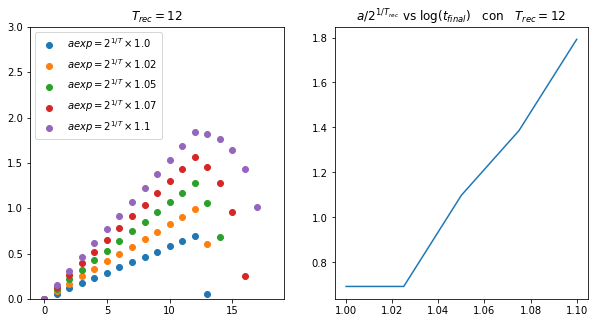

In [75]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

T=12

tcs=[]

fig,axs = plt.subplots(1,2,figsize=(10,5))
print(ax)
ax = axs[0]

for a0 in np.linspace(1.,1.1,5):
    a = a0 * 2**(1/T)
    history = [1.]

    for t in range(T):
        history.append(history[-1]*a)

    for t in range(200):
        newval = max(0.,history[-1]*a - history[-T])
        if newval == 0.:
            tcs.append([a0,t])
            break
        history.append(newval)

    ax.scatter(np.array(range(len(history))),np.log(history),label="$aexp=2^{1/T}\\times"+str(  int(100*a0)/100. )+"$")
    ax.set_title("$T_{rec}="+str(T)+"$")
    ax.set_ylim(0,3)
    
ax.legend()
ax = axs[1]
tcs = np.array(tcs)
tcs12b = tcs
ax.plot(tcs[:,0],np.log(tcs[:,1]))
ax.set_title("$a/2^{1/T_{rec}}$ vs $\\log(t_{final})$   con   $T_{rec}="+str(T)+"$")

AxesSubplot(0.547727,0.125;0.352273x0.755)


Text(0.5, 1.0, '$a/2^{1/T_{rec}}$ vs $\\log(t_{final})$   con   $T_{rec}=14$')

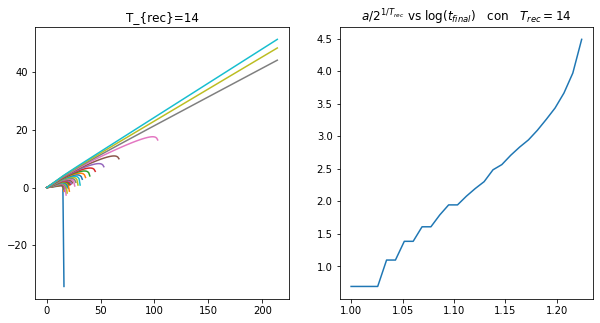

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

T=14

tcs=[]

fig,axs = plt.subplots(1,2,figsize=(10,5))
print(ax)
ax = axs[0]

for a0 in np.linspace(1.,1.25,30):
    a = a0 * 2**(1/T)
    history = [1.]

    for t in range(T):
        history.append(history[-1]*a)

    for t in range(200):
        newval = max(0.,history[-1]*a - history[-T])
        if newval == 0.:
            tcs.append([a0,t])
            break
        history.append(newval)

    ax.plot(np.log(history),label="$aexp=2^{1/T}\\times"+str(  int(100*a0)/100. )+"$")
    ax.set_title("T_{rec}="+str(T))


ax = axs[1]
tcs = np.array(tcs)
tcs14 = tcs
ax.plot(tcs[:,0],np.log(tcs[:,1]))
ax.set_title("$a/2^{1/T_{rec}}$ vs $\\log(t_{final})$   con   $T_{rec}="+str(T)+"$")

AxesSubplot(0.547727,0.125;0.352273x0.755)


Text(0.5, 1.0, '$a/2^{1/T_{rec}}$ vs $\\log(t_{final})$   con   $T_{rec}=21$')

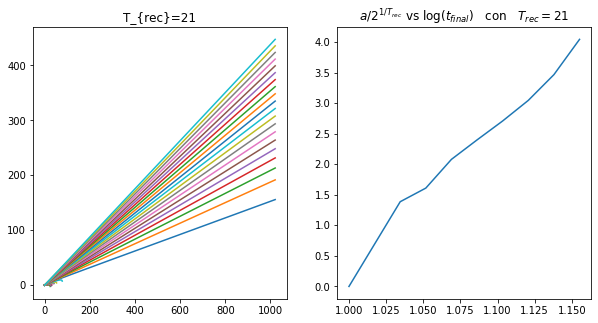

In [66]:
T=21

tcs=[]

fig,axs = plt.subplots(1,2,figsize=(10,5))
print(ax)
ax = axs[0]

for a0 in np.linspace(1.,1.5,30):
    a = a0 * 2**(1/T)
    history = [1.]

    for t in range(T):
        history.append(history[-1]*a)

    for t in range(1000):
        newval = max(0.,history[-1]*a - history[-T])
        if newval == 0.:
            tcs.append([a0,t])
            break
        history.append(newval)

    ax.plot(np.log(history),label="$aexp=2^{1/T}\\times"+str(  int(100*a0)/100. )+"$")
    ax.set_title("T_{rec}="+str(T))


ax = axs[1]
tcs = np.array(tcs)
tcs21 = tcs
ax.plot(tcs[:,0],np.log(tcs[:,1]))
ax.set_title("$a/2^{1/T_{rec}}$ vs $\\log(t_{final})$   con   $T_{rec}="+str(T)+"$")

AxesSubplot(0.547727,0.125;0.352273x0.755)


Text(0.5, 1.0, '$a/2^{1/T_{rec}}$ vs $\\log(t_{final})$   con   $T_{rec}=7$')

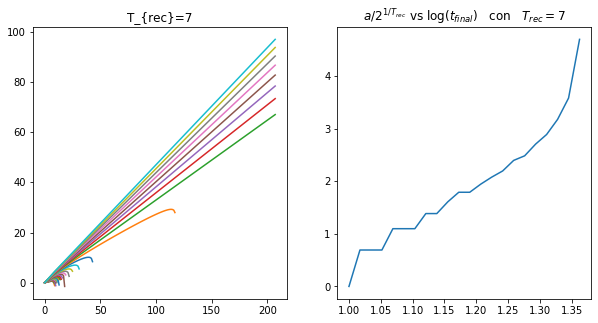

In [61]:

T=7

tcs=[]

fig,axs = plt.subplots(1,2,figsize=(10,5))
print(ax)
ax = axs[0]

for a0 in np.linspace(1.,1.5,30):
    a = a0 * 2**(1/T)
    history = [1.]

    for t in range(T):
        history.append(history[-1]*a)

    for t in range(200):
        newval = max(0.,history[-1]*a - history[-T])
        if newval == 0.:
            tcs.append([a0,t])
            break
        history.append(newval)

    ax.plot(np.log(history),label="$aexp=2^{1/T}\\times"+str(  int(100*a0)/100. )+"$")
    ax.set_title("T_{rec}="+str(T))


ax = axs[1]
tcs = np.array(tcs)
tcs7 = tcs
ax.plot(tcs[:,0],np.log(tcs[:,1]))
ax.set_title("$a/2^{1/T_{rec}}$ vs $\\log(t_{final})$   con   $T_{rec}="+str(T)+"$")

AxesSubplot(0.547727,0.125;0.352273x0.755)


Text(0.5, 1.0, '$a/2^{1/T_{rec}}$ vs $\\log(t_{final})$   con   $T_{rec}=12$')

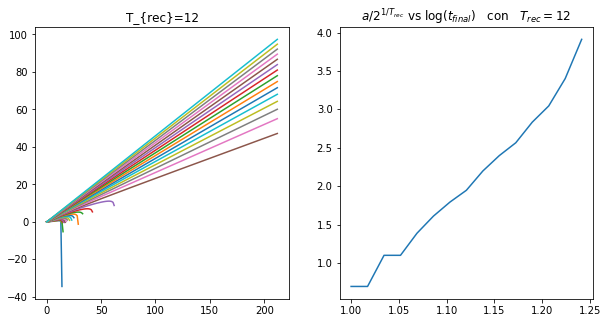

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

T=12

tcs=[]

fig,axs = plt.subplots(1,2,figsize=(10,5))
print(ax)
ax = axs[0]

for a0 in np.linspace(1.,1.5,30):
    a = a0 * 2**(1/T)
    history = [1.]

    for t in range(T):
        history.append(history[-1]*a)

    for t in range(200):
        newval = max(0.,history[-1]*a - history[-T])
        if newval == 0.:
            tcs.append([a0,t])
            break
        history.append(newval)

    ax.plot(np.log(history),label="$aexp=2^{1/T}\\times"+str(  int(100*a0)/100. )+"$")
    ax.set_title("T_{rec}="+str(T))


ax = axs[1]
tcs = np.array(tcs)
tcs12 = tcs
ax.plot(tcs[:,0],np.log(tcs[:,1]))
ax.set_title("$a/2^{1/T_{rec}}$ vs $\\log(t_{final})$   con   $T_{rec}="+str(T)+"$")

AxesSubplot(0.547727,0.125;0.352273x0.755)


Text(0.5, 1.0, '$a/2^{1/T_{rec}}$ vs $\\log(t_{final})$   con   $T_{rec}=5$')

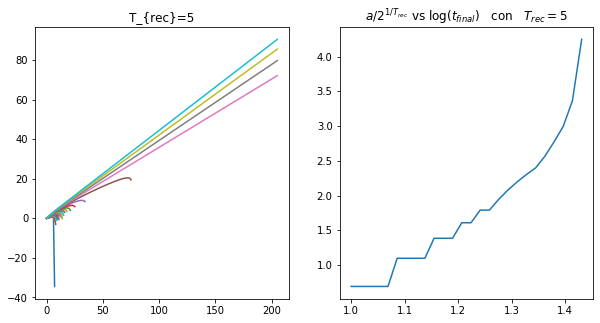

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

T=5

tcs=[]

fig,axs = plt.subplots(1,2,figsize=(10,5))
print(ax)
ax = axs[0]

for a0 in np.linspace(1.,1.5,30):
    a = a0 * 2**(1/T)
    history = [1.]

    for t in range(T):
        history.append(history[-1]*a)

    for t in range(200):
        newval = max(0.,history[-1]*a - history[-T])
        if newval == 0.:
            tcs.append([a0,t])
            break
        history.append(newval)

    ax.plot(np.log(history),label="$aexp=2^{1/T}\\times"+str(  int(100*a0)/100. )+"$")
    ax.set_title("T_{rec}="+str(T))


ax = axs[1]
tcs = np.array(tcs)
tcs5 = tcs
ax.plot(tcs[:,0],np.log(tcs[:,1]))
ax.set_title("$a/2^{1/T_{rec}}$ vs $\\log(t_{final})$   con   $T_{rec}="+str(T)+"$")

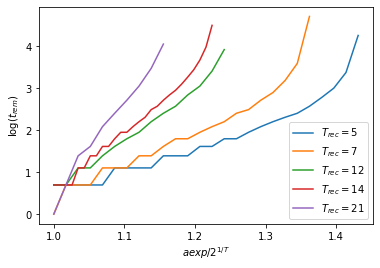

In [69]:
plt.plot(tcs5[:,0],np.log(tcs5[:,1]),label="$T_{rec}=5$")
plt.plot(tcs7[:,0],np.log(tcs7[:,1]),label="$T_{rec}=7$")
plt.plot(tcs12[:,0],np.log(tcs12[:,1]),label="$T_{rec}=12$")
plt.plot(tcs14[:,0],np.log(tcs14[:,1]),label="$T_{rec}=14$")
plt.plot(tcs21[:,0],np.log(tcs21[:,1]),label="$T_{rec}=21$")
plt.ylabel("$\\log(t_{rem})$")
plt.xlabel("$aexp/2^{1/T}$")
plt.legend()